In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
import optuna
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


In [2]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


In [3]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([-0.0003, -0.0019,  0.0305,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

torch.Size([1, 30, 20]) tensor([7.2616e-07, 4.1540e-04, 8.8877e-03, 3.0846e-03, 6.3033e-04, 2.2232e-04,
        1.1757e-04, 1.2526e-04, 2.6362e-04, 6.6412e-03, 9.9964e-03, 1.1368e-04,
        8.1976e-05, 2.9191e-05, 2.2713e-05, 5.5024e-05, 2.4458e-03, 1.7340e-02,
        2.1770e-02, 1.4173e-02, 1.5771e-02, 2.0890e-02, 1.6473e-02, 1.9104e-03,
        1.3787e-05, 5.6276e-07, 2.2755e-07, 8.2184e-08, 1.0918e-08, 0.0000e+00])
('tom_low', 1) tensor(1) 44100


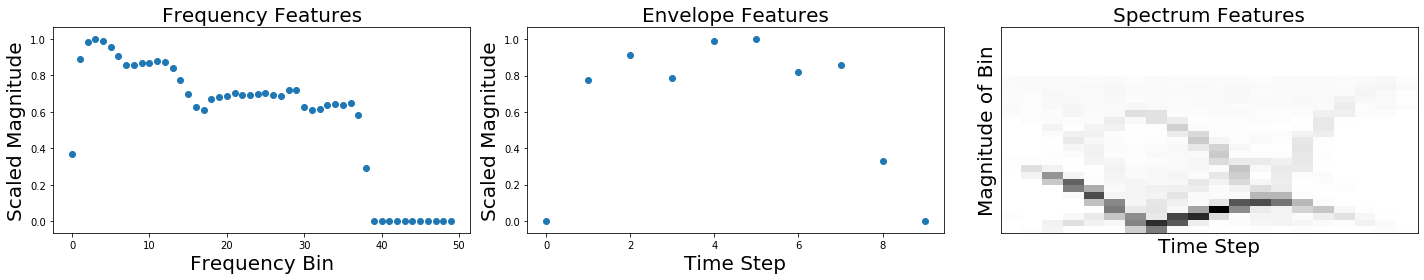

In [4]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [5]:
class AE_Linear_1H(nn.Module):
    def __init__(self,compression_dim=64,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.dropout(torch.relu(activation))
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Linear_2H(nn.Module):
    def __init__(self,compression_dim=8,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer1 = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=128, out_features=32
        )
        self.encoder_output_layer = nn.Linear(
            in_features=32, out_features=compression_dim
        )
        self.decoder_hidden_layer1 = nn.Linear(
            in_features=compression_dim, out_features=32
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = self.dropout(torch.relu(activation))
        h1_out = self.encoder_hidden_layer2(activation)
        h1_out = self.dropout(torch.relu(h1_out))
        code = self.encoder_output_layer(h1_out)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer1(code)
        activation = self.decoder_hidden_layer2(activation)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Conv(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5):
        super(AE_Conv, self).__init__()
        self.W=input_shape[0]
        self.H=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=num_channels, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//2 * self.W//2) * 8, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [6]:
compression_dim=8
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.50,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)

train_synthless=train[train["label_num"]==0]
test_synthless=test[test["label_num"]==0]
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)


/home/asalimi/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
def objective(trial):

    #hyper params
    learning_rate = trial.suggest_uniform('Learning Rate', 1e-4,1e-1)
    dropout_rate = trial.suggest_discrete_uniform('Dropout Rate', 0,0.5,0.1)
    latent_size = trial.suggest_categorical('Latent Size',[4, 16, 64])
    optimizer_type = trial.suggest_categorical('Optimizer', ['Adam', 'SGD'])
    FREQ_BINS = trial.suggest_categorical('Frequency Bins', [10, 30, 60])
    TIME_STEPS = trial.suggest_categorical('Time Steps', [10, 20])
    hidden_layers= trial.suggest_int('Hidden Layers', 1, 2)
    l2=trial.suggest_loguniform('L2 Regularization', 1e-6,1e-1)
    model_type=trial.suggest_categorical('Model Type', ['CNN', 'FC'])
    num_channels=5

    spec_dimension=FREQ_BINS*TIME_STEPS

    criterion=nn.MSELoss()
    
    #make model
    if hidden_layers==1:
        model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    else:
        model = AE_Linear_2H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    if model_type=="CNN":
        model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=num_channels).to(device)
        
    if optimizer_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    elif optimizer_type=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=l2)
    #make dataloader 
    ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
    spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
    spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
    spec_data_test_nosynth = audioDataset(test_synthless,".",task="dvn", transform=ptTune)
    spec_test_nosynth_loader= DataLoader(spec_data_test_nosynth, batch_size=16,shuffle=True, num_workers=8)
    #train
    epochs=40
    for epoch in range(epochs):
        loss = 0
        for batch_features in spec_train_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(spec_train_nosynth_loader)
        test_loss=0
        with torch.no_grad():
            for batch_features in spec_test_nosynth_loader:
                batch_features=batch_features["feats"]
                batch_features = batch_features.view(-1, spec_dimension).to(device)
                outputs = model(batch_features)
                temp_loss = criterion(outputs, batch_features)
                test_loss += temp_loss.item()
        test_loss = test_loss / len(spec_test_nosynth_loader) 
        trial.report(test_loss, epoch)   
        if epoch%2==0:
            if trial.should_prune():
                raise optuna.TrialPruned()
        print("epoch : {}/{}, loss = {:.6f}, test_loss = {:.6f}".format(epoch, epochs, loss,test_loss))
    return test_loss
study = optuna.create_study(study_name='Study_ALL',sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner(), storage='sqlite:///optuna_median.db',load_if_exists=True)
study.optimize(objective, n_trials=50)

/home/asalimi/miniconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: HyperbandPruner is experimental (supported from v1.1.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-21 23:05:05,181] Using an existing study with name 'Study_ALL' instead of creating a new one.


epoch : 0/40, loss = 0.002656, test_loss = 0.001864
epoch : 1/40, loss = 0.001730, test_loss = 0.001591
epoch : 2/40, loss = 0.001537, test_loss = 0.001534
epoch : 3/40, loss = 0.001422, test_loss = 0.001374
epoch : 4/40, loss = 0.001324, test_loss = 0.001331
epoch : 5/40, loss = 0.001278, test_loss = 0.001242
epoch : 6/40, loss = 0.001261, test_loss = 0.001287
epoch : 7/40, loss = 0.001225, test_loss = 0.001225
epoch : 8/40, loss = 0.001200, test_loss = 0.001196
epoch : 9/40, loss = 0.001188, test_loss = 0.001199


In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
import joblib
joblib.dump(study, 'study2.pkl')
study2 = joblib.load('study2.pkl')
print('Best trial until now:')
print(' Value: ', study2.best_trial.value)
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')